In [31]:
import core.cg_core
AbstractConjugateGradient = core.cg_core.AbstractConjugateGradient
CGAnalyzer = core.cg_core.CGAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.sparse as sparse
from tqdm import tqdm
from scipy import signal


def ReadImageAsNumpy(file:str):
    img = Image.open(file)
    numpydata = np.asarray(img, dtype=np.float32)
    return numpydata


def BoxBlur(Image:np.ndarray, boxsize=5, boundary="fill"):
    assert Image.ndim == 2 or Image.ndim == 3, \
         "Should be a matrix, or a 3d tensor. "
    if Image.ndim == 3:
        assert Image.shape[2] == 3, \
            "Image should have 3 color channels on the last axis. "
    Kernel = np.ones((boxsize, boxsize))/boxsize**2
    # Kernel = np.array([[0, 1, 0], [1, -3, 1], [0, 1, 0]])
    if Image.ndim == 2:
        Blur = Image + signal.convolve2d(Image, Kernel, boundary=boundary, mode='same')
        return Blur
    else:
        Blurred = np.zeros(Image.shape)
        for II in range(Image.shape[2]):
            Blurred[..., II] = \
                signal.convolve2d(Image[..., II], Kernel, boundary=boundary, mode='same')
        return Blurred


def SuccessiveBlurr(Image: np.ndarray, boxsize=5, times=3):
    Blurred = Image
    for __ in range(times):
        Blurred = BoxBlur(Blurred, boxsize=boxsize)
    return Blurred


import os
import sys
print(f"curdir: {os.curdir}")
print(f"cwd: {os.getcwd()}" )
print(f"exec: {sys.executable}")

curdir: .
cwd: C:\Users\victo\source\repos\Serious-Python-Stuff\Conjugate_Gradient
exec: c:\users\victo\source\repos\pyenvs\py39_math\scripts\python.exe


---
**Prepare The Image**
* Read
* DownScale
* Blurr
* Plot

In [49]:
TheImage = ReadImageAsNumpy(".\\data\\image2.png")
TheImage /= 255
# TheImage = np.mean(TheImage, axis=2)
Matrix = TheImage[0:-1:5, 0:-1:5, :3]
N = 2
BoxSize= 7
Height, Width, _ = Matrix.shape

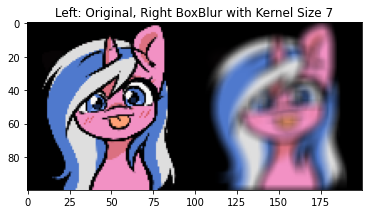

In [50]:
Blurred = BoxBlur(Matrix, boxsize=BoxSize)
ToPlot = np.zeros((Height, Width*2, 3))
ToPlot[:, :Width, :], ToPlot[:, Width:, :] = Matrix, Blurred
plt.imshow(ToPlot)
plt.title(f"Left: Original, Right BoxBlur with Kernel Size {BoxSize}")
plt.show()

---
**Deblur the Image with Conjugate Gradient While Collecting Data**
* Give the black box
* Run the Conjugate Gradient Algorithm
* Get the recovered image

77it [00:01, 76.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


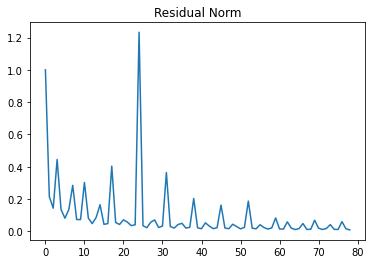

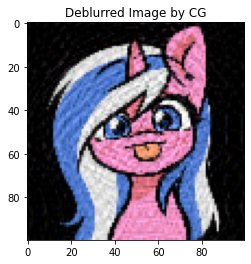

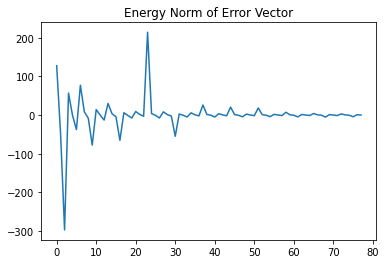

In [51]:
Analyzer = CGAnalyzer(
    lambda x: BoxBlur(x, boxsize=BoxSize),
    Blurred,
    np.ones(Matrix.shape)
)
EnergyNorm = []
for II, (x, r) in tqdm(enumerate(Analyzer.Generate(maxitr=5000))):
    E = x - Matrix
    EnergyNorm.append(
        np.sum(E*BoxBlur(E, boxsize=BoxSize))
    )
    if r < 1e-2:
        break

plt.plot(Analyzer.ResidualNorm); plt.title("Residual Norm")
plt.show()
plt.imshow(Analyzer.BestSolution); plt.title("Deblurred Image by CG")
plt.show()
plt.plot(EnergyNorm); plt.title("Energy Norm of Error Vector")
plt.show()

---
**Negative Energy Norm -> This Should not work at all**

The Energy Norm of the error is not monotonically decreasing, meanin that the matrix is not Positive Definite. **Conjugate gradient won't garantee convergence in this case**.

But in this case, it worked for some reasons. But in general, it should not work, because if the energy norm of the transformation is negative, it implies that the linear transformation is not positive semidefinite (Which means that it could be a saddle parabolic for the objective function, which doesn't have minimum). But I am confident that the matrix is symmetric **IF** the kernel size is odd.

**Successive Blurring**

Blur the same image, but 2 times.

Text(0.5, 1.0, 'Left: Original, Right BoxBlur with Kernel Size 5, repetition 2')

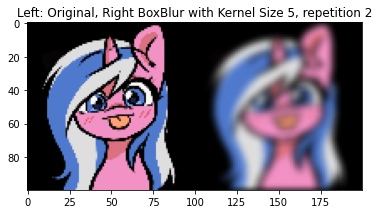

In [35]:
N = 2
BoxSize= 5
BlackBox = lambda x: SuccessiveBlurr(x, boxsize=BoxSize, times=N)
Blurred = BlackBox(Matrix)
ToPlot = np.zeros((Height, Width*2, 3))
ToPlot[:, :Width, :], ToPlot[:, Width:, :] = Matrix, Blurred
plt.imshow(ToPlot)
plt.title(f"Left: Original, Right BoxBlur with Kernel Size {BoxSize}, repetition {N}")

106it [00:02, 37.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


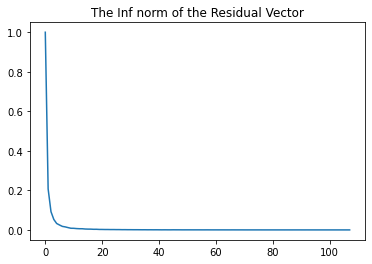

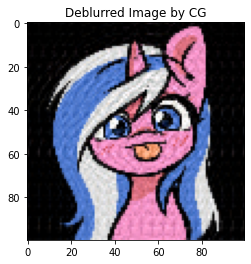

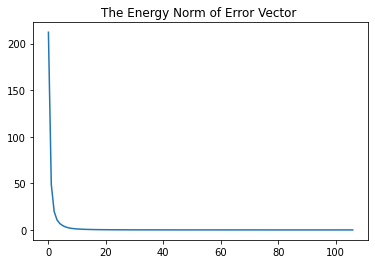

In [36]:
Analyzer = CGAnalyzer(
    BlackBox,
    Blurred,
    np.ones(Matrix.shape)
)
EnergyNorm = []
for II, (x, r) in tqdm(enumerate(Analyzer.Generate(maxitr=2000))):
    E = x - Matrix
    EnergyNorm.append(
        np.sum(E*BlackBox(E))
    )
    if r < 1e-4:
        break

plt.plot(Analyzer.ResidualNorm); plt.title("The Inf norm of the Residual Vector")
plt.show()
plt.imshow(Analyzer.BestSolution); plt.title("Deblurred Image by CG")
plt.show()
plt.plot(EnergyNorm); plt.title("The Energy Norm of Error Vector ")
plt.show()

this time around,
$A^2 = A^TA $, $A^TA$ will always positive semi-definite (Positive definite if the boundary conditions are Dirichelet for the 2d convolution ("fill" with zeros for example)). Whenever we blur the image even number of times, the CG solver will be able to minimize the energy norm of the error vector properly.

Yes, if you try N = 3, then we will have negative energy norm again.

Observe the smooth decay of the energy norm.


---
### When thing fails?

* The kernel size is odd, cause the matrix representation of the convolution to be non-symmetric.
* Odd number of repeatition, causig the matrix representation of the convolution to be non positive-definite.


### **Symmetric Matrix Representation and Double Blurring Exploit**

$$$$
\begin{aligned}
    Ax &= b
    \\
    A^TAx &= A^Tb
    \\
    A^2x &= Ab
\end{aligned}
$$$$

Instead of solving the first problem directly, we make use of the fact that $A$ is symmetric (Odd sized kernel), and then interpret $A$ as double blurring.

Now we have a deblurr algorithm that works for all odd kernel size.

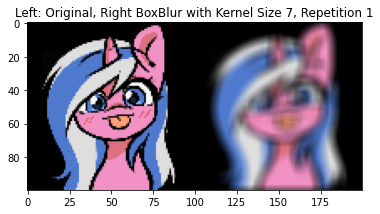

In [54]:
BoxSize = 7
N = 1
BlackBox = lambda x: SuccessiveBlurr(x, boxsize=BoxSize, times=N)
Blurred = BlackBox(Matrix)
ToPlot = np.zeros((Height, Width*2, 3))
ToPlot[:, :Width, :], ToPlot[:, Width:, :] = Matrix, Blurred
plt.imshow(ToPlot)
plt.title(f"Left: Original, Right BoxBlur with Kernel Size {BoxSize}, Repetition {N}")
plt.show()

115it [00:02, 47.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


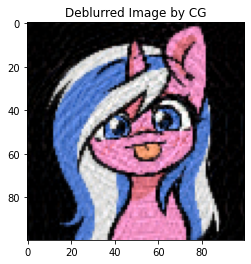

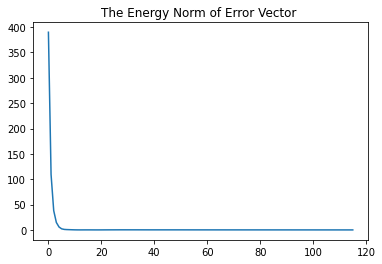

In [55]:
Analyzer = CGAnalyzer(
    lambda x: BlackBox(BlackBox(x)),
    BlackBox(Blurred),
    np.ones(Matrix.shape)
)
EnergyNorm = []
for II, (x, r) in tqdm(enumerate(Analyzer.Generate(maxitr=2000))):
    E = x - Matrix
    EnergyNorm.append(
        np.sum(E*BlackBox(E))
    )
    if r < 1e-4:
        break

plt.imshow(Analyzer.BestSolution); plt.title("Deblurred Image by CG")
plt.show()
plt.plot(EnergyNorm); plt.title("The Energy Norm of Error Vector ")
plt.show()